In [31]:
# Portions of this work were assisted by ChatGPT, a language model developed by OpenAI (2025). https://openai.com/chatgpt

from google.colab import files
uploaded = files.upload()


Saving cleaned_data_combined_modified.csv to cleaned_data_combined_modified (2).csv


In [32]:
import pandas as pd
import re
import numpy as np

In [33]:
file_path = 'cleaned_data_combined_modified.csv'
try:
    df = pd.read_csv(file_path)
    print("✅ File loaded successfully")
except Exception as e:
    print(f"❌ Failed to load file: {e}")

✅ File loaded successfully


In [34]:
# Cleaning Q1

def clean_q1(text):
    if pd.isnull(text):
        return None

    text = str(text).strip().lower()

    # Extract the first digit between 1 and 5
    match = re.search(r'\b([1-5])\b', text)
    if match:
        return int(match.group(1))

    return None

# Locate Q1 column
q1_col = None
for col in df.columns:
    if 'q1' in col.strip().lower():
        q1_col = col
        break

if q1_col is None:
    raise ValueError("Q1 column not found.")

# Apply cleaning function
df[q1_col] = df[q1_col].apply(clean_q1)

# Impute missing values with the median
df[q1_col] = df[q1_col].fillna(df[q1_col].median())

In [35]:
# Cleaning Q2

import re
import pandas as pd
import numpy as np

# Word-to-number mapping
word_to_number = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12
}

def words_to_digits(text):
    for word, digit in word_to_number.items():
        pattern = r'\b' + word + r'\b'
        text = re.sub(pattern, str(digit), text)
    return text

def clean_q2(text):
    if pd.isnull(text):
        return None

    text = str(text).lower().strip()
    text = words_to_digits(text)
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    text = re.sub(r'[$€£]|cad|canadian|dollars?|usd', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Handle messy ranges like "3 - 5", "3to5", "3 or 4"
    range_pattern = r'(\d+(?:\.\d+)?)\s*(?:-|–|to|or|~|—)\s*(\d+(?:\.\d+)?)'
    range_match = re.search(range_pattern, text)
    if range_match:
        try:
            low = float(range_match.group(1))
            high = float(range_match.group(2))
            return round((low + high) / 2)
        except:
            pass

    # Extract all standalone numbers
    numbers = re.findall(r'\d+(?:\.\d+)?', text)

    # If user writes "x ingredients" (e.g., "5 ingredients"), prioritize that
    ing_match = re.search(r'(\d+(?:\.\d+)?)\s+ingredients?', text)
    if ing_match:
        return round(float(ing_match.group(1)))

    # Numeric list (comma/and-separated): count if clear list
    if ',' in text or ' and ' in text:
        items = re.split(r',| and ', text)
        items = [item.strip() for item in items if item.strip()]
        if items:
            return len(items)

    # General fallback: average all numbers found
    if len(numbers) > 1:
        return round(sum(map(float, numbers)) / len(numbers))
    elif len(numbers) == 1:
        return round(float(numbers[0]))

    # Handle vague terms
    vague_words = ['many', 'a lot', 'several', 'tons', 'bunch', 'plenty', 'idk', 'don’t know', "don't know", 'not sure']
    if any(word in text for word in vague_words):
        return None

    return None

# Locate Q2 column
q2_col = next((col for col in df.columns if 'q2' in col.strip().lower()), None)
if q2_col is None:
    raise ValueError("Q2 column not found.")

# Apply cleaning function and fill missing with median
df[q2_col] = df[q2_col].apply(clean_q2)
df[q2_col] = df[q2_col].fillna(df[q2_col].median())

print(f"✅ Q2 cleaned. Example values:\n{df[q2_col].head(30)}")


✅ Q2 cleaned. Example values:
0      6.0
1      2.0
2      5.0
3      6.0
4      3.0
5      6.0
6      4.0
7      4.0
8      5.0
9      9.0
10    10.0
11     6.0
12     4.0
13     4.0
14     8.0
15     5.0
16     7.0
17     6.0
18     2.0
19     6.0
20    10.0
21     5.0
22     5.0
23    10.0
24     6.0
25     6.0
26    10.0
27     5.0
28     3.0
29     5.0
Name: Q2: How many ingredients would you expect this food item to contain?, dtype: float64


In [36]:
# Cleaning Q3

# List of known settings (lowercased)
setting_options = {
    'is_Week_day_lunch': 'week day lunch',
    'is_Week_day_dinner': 'week day dinner',
    'is_Weekend_lunch': 'weekend lunch',
    'is_Weekend_dinner': 'weekend dinner',
    'is_At_a_party': 'at a party',
    'is_Late_night_snack': 'late night snack'
}

# Locate Q3 column
q3_col = None
for col in df.columns:
    if 'q3' in col.strip().lower():
        q3_col = col
        break

if q3_col is None:
    raise ValueError("Q3 column not found.")

# Create binary columns for each setting
for new_col, keyword in setting_options.items():
    df[new_col] = df[q3_col].apply(
        lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
    )

# Drop the original Q3 column
df.drop(columns=[q3_col], inplace=True)


In [37]:
import re
import pandas as pd
import numpy as np

def clean_q4(text):
    """
    Cleans Q4 price estimates:
    - Extracts and averages ranges or multiple values
    - Removes currency symbols/words
    - Handles messy structures and floating point numbers
    """
    if pd.isnull(text):
        return None

    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Normalize excessive spaces
    text = re.sub(r'[$€£]|cad|canadian|dollars?|usd', '', text)  # Remove currency references
    text = text.replace('~', '-')

    # Handle range expressions like "5-10", "5 to 10", "5 or 10"
    range_pattern = r'(\d+(?:\.\d+)?)\s*(?:-|to|or|–|—)\s*(\d+(?:\.\d+)?)'
    range_match = re.search(range_pattern, text)
    if range_match:
        try:
            low = float(range_match.group(1))
            high = float(range_match.group(2))
            return round((low + high) / 2)
        except:
            pass

    # Extract ALL numbers (may include noise like "one slice $3, full pizza $15")
    all_numbers = re.findall(r'\d+(?:\.\d+)?', text)
    if all_numbers:
        all_numbers = [float(num) for num in all_numbers]
        avg = sum(all_numbers) / len(all_numbers)
        return round(avg)

    return None

# Locate Q4 column
q4_col = next((col for col in df.columns if 'q4' in col.strip().lower()), None)
if q4_col is None:
    raise ValueError("Q4 column not found.")

# Apply cleaning
df[q4_col] = df[q4_col].apply(clean_q4)
df[q4_col] = df[q4_col].fillna(df[q4_col].median())

print(f"✅ Q4 cleaned. Example values:\n{df[q4_col].head(10)}")


✅ Q4 cleaned. Example values:
0     5.0
1     5.0
2    10.0
3     3.0
4     5.0
5    15.0
6     1.0
7    20.0
8     3.0
9     4.0
Name: Q4: How much would you expect to pay for one serving of this food item?, dtype: float64


In [38]:
# CLeaning Q5

import re
from collections import Counter
import numpy as np
import pandas as pd


def tokenize(text):
    """
    Tokenizes input text: lowercase, remove punctuation, split by whitespace.
    """
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def process_q5_bow(df, top_n=50, binary=True):
    """
    Converts Q5 text responses into Bag-of-Words features.

    Args:
        df: Input DataFrame
        top_n: Keep top N most frequent tokens
        binary: If True, encodes presence (1) or absence (0). If False, uses frequency count.

    Returns:
        DataFrame with new BoW features and Q5 column removed.
    """
    # Locate Q5 column
    q5_col = next((col for col in df.columns if 'q5' in col.strip().lower()), None)
    if q5_col is None:
        raise ValueError("Q5 column not found in the dataset.")

    # Tokenize Q5 responses
    token_lists = df[q5_col].fillna('').apply(tokenize)

    # Count total frequencies
    term_freq = Counter()
    for tokens in token_lists:
        term_freq.update(tokens)

    # Select top-N vocabulary
    vocab = [term for term, _ in term_freq.most_common(top_n)]
    vocab_set = set(vocab)

    # Create BoW features
    bow_features = []
    for tokens in token_lists:
        token_counts = Counter(tokens)
        row = {}
        for word in vocab:
            if binary:
                row[f"q5_bow_{word}"] = int(word in token_counts)
            else:
                row[f"q5_bow_{word}"] = token_counts[word]
        bow_features.append(row)

    bow_df = pd.DataFrame(bow_features)

    # Concatenate BoW with original df (drop original Q5 column)
    df = df.drop(columns=[q5_col]).reset_index(drop=True)
    df = pd.concat([df, bow_df], axis=1)

    return df

# Example usage
df = process_q5_bow(df, top_n=350, binary=True)


In [39]:
# Locate Q6 column
q6_col = next((col for col in df.columns if 'q6' in col.strip().lower()), None)
if q6_col is None:
    raise ValueError("Q6 column not found.")

# Define drink categories
drink_keywords = {
    'is_soda': [
        'soda', 'cola', 'coke', 'coca', 'sprite', 'fanta',
        'root beer', 'dr pepper', 'pepsi', '7up', 'mountain dew', 'cream soda', 'seven up'
    ],
    'is_juice': [
        'juice', 'orange juice', 'apple juice', 'grape juice', 'cranberry', 'lemonade'
    ],
    'is_energy': [
        'red bull', 'monster', 'rockstar', 'energy drink'
    ],
    'is_water': [
        'water', 'bottled water', 'tap water', 'sparkling water'
    ],
    'is_tea': [
        'tea', 'iced tea', 'green tea', 'bubble tea'
    ],
    'is_coffee': [
        'coffee', 'latte', 'espresso', 'cappuccino', 'cold brew'
    ],
    'is_milk': [
        'milk', 'chocolate milk', 'almond milk', 'soy milk', 'oat milk'
    ]
}

# Clean and encode each category
def detect_drink_category(text, keywords):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return 1 if any(kw in text for kw in keywords) else 0

# Apply to dataframe
for col_name, keywords in drink_keywords.items():
    df[col_name] = df[q6_col].apply(lambda x: detect_drink_category(x, keywords))

# Drop original Q6 column
df.drop(columns=[q6_col], inplace=True)

print("✅ Q6 cleaned into multiple drink categories.")


✅ Q6 cleaned into multiple drink categories.


In [40]:
# Cleaning Q7

q7_col = None
for col in df.columns:
    if 'q7' in col.strip().lower():
        q7_col = col
        break

if q7_col is None:
    raise ValueError("Q7 column not found.")

# Define group keywords
q7_targets = {
    'is_Parents': 'parents',
    'is_Siblings': 'siblings',
    'is_Friends': 'friends',
    'is_Teachers': 'teachers',
    'is_Strangers': 'strangers'
}

# Create binary columns for each group
for new_col, keyword in q7_targets.items():
    df[new_col] = df[q7_col].apply(
        lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
    )

# Drop original Q7 column
df.drop(columns=[q7_col], inplace=True)


In [41]:
# Cleaning Q8

# Locate Q8 column
q8_col = None
for col in df.columns:
    if 'q8' in col.strip().lower():
        q8_col = col
        break

if q8_col is None:
    raise ValueError("Q8 column not found.")

# Map known responses to spice levels
def map_spice_level(text):
    if not isinstance(text, str):
        return 0  # Default for missing

    t = text.lower()
    if 'none' in t:
        return 0
    elif 'mild' in t or 'little' in t:
        return 1
    elif 'moderate' in t or 'medium' in t:
        return 2
    elif 'hot' in t and 'lot' in t:
        return 3
    elif 'my hot sauce' in t:
        return 4  # enthusiastic
    else:
        return 0  # fallback

# Apply to dataset
df['spice_level'] = df[q8_col].apply(map_spice_level)

# Drop original column
df.drop(columns=[q8_col], inplace=True)

# Drop the ID column if it exists
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)


In [42]:
output_path = 'clean_dataset.csv'
df.to_csv(output_path, index=False)

print(f"Data cleaning complete. The cleaned file is saved as '{output_path}'.")

Data cleaning complete. The cleaned file is saved as 'clean_dataset.csv'.


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


In [44]:
# Drop missing labels (if any)
df = df.dropna(subset=["Label"])

# Features (everything except label)
X = df.drop(columns=["Label"])
y = df["Label"]


In [45]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% val of remaining → 60% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=30, stratify=y_temp)


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

best_model = None
best_score = 0
best_params = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Recombine train + val sets for full cross-validation
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

for depth in [3, 5, 7, 9, 12, None]:
    for min_split in [2, 5, 10]:
        for min_leaf in [1, 2, 4]:
            fold_accuracies = []

            for train_idx, val_idx in skf.split(X_train_val, y_train_val):
                X_fold_train, X_fold_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
                y_fold_train, y_fold_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

                model = DecisionTreeClassifier(
                    max_depth=depth,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    random_state=42
                )

                model.fit(X_fold_train, y_fold_train)
                val_pred = model.predict(X_fold_val)
                acc = accuracy_score(y_fold_val, val_pred)
                fold_accuracies.append(acc)

            avg_acc = np.mean(fold_accuracies)

            print(f"[CV avg: {round(avg_acc, 4)}] depth={depth}, split={min_split}, leaf={min_leaf}")

            if avg_acc > best_score:
                best_score = avg_acc
                best_model = model
                best_params = {
                    "max_depth": depth,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf
                }

print("✅ Best Decision Tree Hyperparameters (CV):", best_params)
print("✅ Best CV Accuracy:", round(best_score, 4))


[CV avg: 0.8076] depth=3, split=2, leaf=1
[CV avg: 0.8076] depth=3, split=2, leaf=2
[CV avg: 0.8076] depth=3, split=2, leaf=4
[CV avg: 0.8076] depth=3, split=5, leaf=1
[CV avg: 0.8076] depth=3, split=5, leaf=2
[CV avg: 0.8076] depth=3, split=5, leaf=4
[CV avg: 0.8076] depth=3, split=10, leaf=1
[CV avg: 0.8076] depth=3, split=10, leaf=2
[CV avg: 0.8076] depth=3, split=10, leaf=4
[CV avg: 0.8266] depth=5, split=2, leaf=1
[CV avg: 0.8297] depth=5, split=2, leaf=2
[CV avg: 0.8243] depth=5, split=2, leaf=4
[CV avg: 0.8259] depth=5, split=5, leaf=1
[CV avg: 0.8304] depth=5, split=5, leaf=2
[CV avg: 0.8243] depth=5, split=5, leaf=4
[CV avg: 0.8274] depth=5, split=10, leaf=1
[CV avg: 0.8319] depth=5, split=10, leaf=2
[CV avg: 0.8281] depth=5, split=10, leaf=4
[CV avg: 0.8152] depth=7, split=2, leaf=1
[CV avg: 0.8137] depth=7, split=2, leaf=2
[CV avg: 0.7977] depth=7, split=2, leaf=4
[CV avg: 0.8152] depth=7, split=5, leaf=1
[CV avg: 0.8152] depth=7, split=5, leaf=2
[CV avg: 0.7977] depth=7, sp

In [47]:
# Final training on full training+validation
best_model.fit(X_train_val, y_train_val)

# Test evaluation
y_test_pred = best_model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

       Pizza       0.91      0.82      0.86       109
    Shawarma       0.78      0.89      0.83       110
       Sushi       0.81      0.77      0.79       110

    accuracy                           0.83       329
   macro avg       0.83      0.83      0.83       329
weighted avg       0.83      0.83      0.83       329



<ipython-input-48-cf3da6bdf938>:21: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


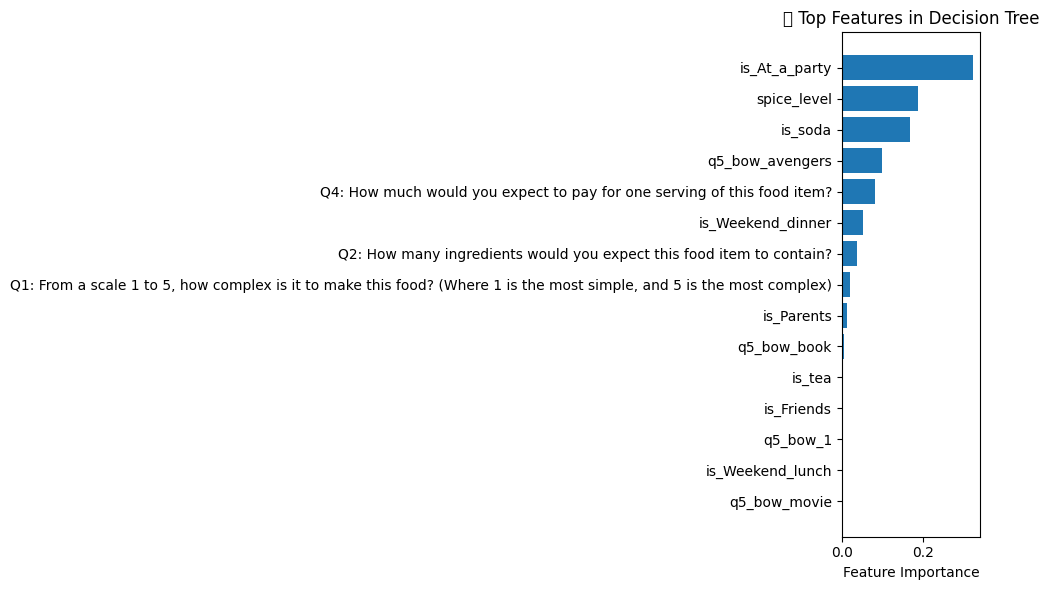

In [48]:
# visualize decision tree and feature importance

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort descending

# Show top N
top_n = 15
top_features = X.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1])  # Reverse for descending bar chart
plt.xlabel("Feature Importance")
plt.title("💡 Top Features in Decision Tree")
plt.tight_layout()
plt.show()


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize search
best_rf_model = None
best_rf_score = 0
best_rf_params = {}
min_leaf = 1

# Create Stratified K-Fold object (preserves label distribution)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Recombine train + val sets for full cross-validation
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)


# Following remaining values were kept after grid search for the following reason
# high validation, test accuracy and consistent behavior across different classes
for n in [250, 300, 350]:
    for depth in [7, 8, 9]:
        for min_split in [10, 15]:
                val_scores = []

                for train_idx, val_idx in skf.split(X_train_val, y_train_val):
                    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
                    y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

                    rf = RandomForestClassifier(
                        n_estimators=n,
                        max_depth=depth,
                        min_samples_split=min_split,
                        random_state=42,
                        max_features='sqrt',
                        n_jobs=-1
                    )
                    rf.fit(X_train_fold, y_train_fold)
                    val_pred = rf.predict(X_val_fold)
                    val_scores.append(accuracy_score(y_val_fold, val_pred))

                avg_score = np.mean(val_scores)

                print(f"[CV avg: {round(avg_score, 4)}] n={n}, depth={depth}, split={min_split}, leaf={min_leaf}")

                if avg_score > best_rf_score:
                    best_rf_score = avg_score
                    best_rf_model = rf
                    best_rf_params = {
                        "n_estimators": n,
                        "max_depth": depth,
                        "min_samples_split": min_split,
                        "min_samples_leaf": min_leaf
                    }


print("✅ Best RF hyperparameters (CV):", best_rf_params)
print("✅ Best RF CV accuracy:", round(best_rf_score, 4))


[CV avg: 0.8814] n=250, depth=7, split=10, leaf=1
[CV avg: 0.8806] n=250, depth=7, split=15, leaf=1
[CV avg: 0.8814] n=250, depth=8, split=10, leaf=1
[CV avg: 0.8806] n=250, depth=8, split=15, leaf=1
[CV avg: 0.8821] n=250, depth=9, split=10, leaf=1
[CV avg: 0.8821] n=250, depth=9, split=15, leaf=1
[CV avg: 0.8829] n=300, depth=7, split=10, leaf=1
[CV avg: 0.8814] n=300, depth=7, split=15, leaf=1
[CV avg: 0.8806] n=300, depth=8, split=10, leaf=1
[CV avg: 0.8814] n=300, depth=8, split=15, leaf=1
[CV avg: 0.8814] n=300, depth=9, split=10, leaf=1
[CV avg: 0.8844] n=300, depth=9, split=15, leaf=1
[CV avg: 0.8837] n=350, depth=7, split=10, leaf=1
[CV avg: 0.8821] n=350, depth=7, split=15, leaf=1
[CV avg: 0.8821] n=350, depth=8, split=10, leaf=1
[CV avg: 0.8806] n=350, depth=8, split=15, leaf=1
[CV avg: 0.8829] n=350, depth=9, split=10, leaf=1
[CV avg: 0.8837] n=350, depth=9, split=15, leaf=1
✅ Best RF hyperparameters (CV): {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 15, 'min_

In [59]:
# # Final fit on all train+val before testing
# saving these Best RF hyperparameters (CV): {'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}
best_rf_model = RandomForestClassifier(
                        n_estimators=250,
                        max_depth=7,
                        min_samples_split=10,
                        random_state=42,
                        max_features='sqrt',
                        n_jobs=-1
                    )
best_rf_model.fit(X_train_val, y_train_val)

y_test_pred_rf = best_rf_model.predict(X_test)
y_train_pred_rf = best_rf_model.predict(X_train)
print("📊 Random Forest Test Performance:")
print(classification_report(y_test, y_test_pred_rf))
print("📊 Random Forest Train Performance:")
print(classification_report(y_train, y_train_pred_rf))


📊 Random Forest Test Performance:
              precision    recall  f1-score   support

       Pizza       0.89      0.91      0.90       109
    Shawarma       0.88      0.90      0.89       110
       Sushi       0.89      0.85      0.87       110

    accuracy                           0.89       329
   macro avg       0.89      0.89      0.89       329
weighted avg       0.89      0.89      0.89       329

📊 Random Forest Train Performance:
              precision    recall  f1-score   support

       Pizza       0.91      0.92      0.92       329
    Shawarma       0.91      0.89      0.90       329
       Sushi       0.91      0.92      0.92       328

    accuracy                           0.91       986
   macro avg       0.91      0.91      0.91       986
weighted avg       0.91      0.91      0.91       986



<ipython-input-52-ff12211038a3>:11: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


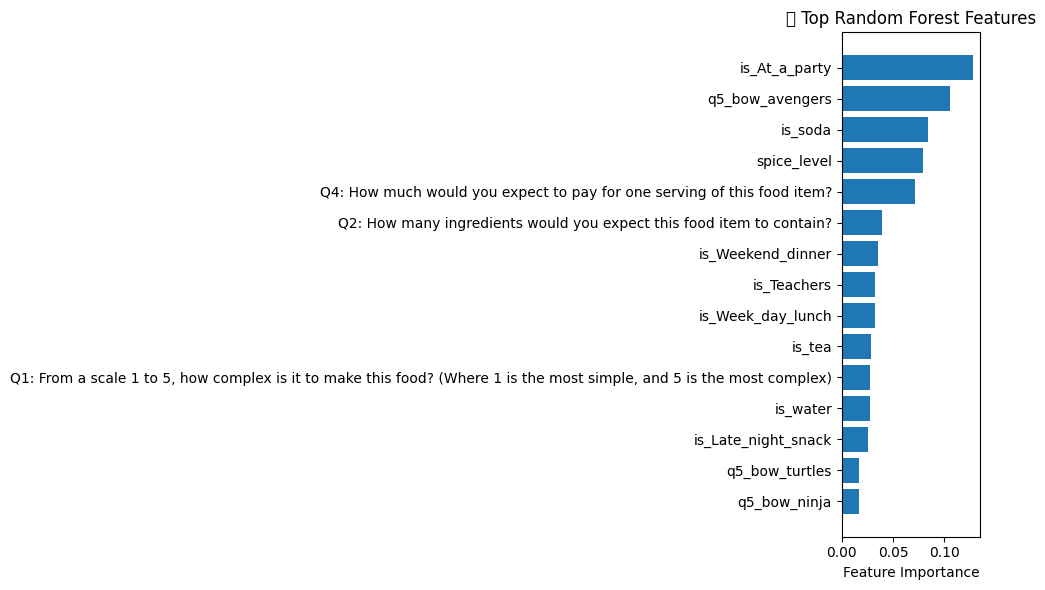

In [52]:
# Visualize Random Forest

importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
plt.barh(X.columns[indices[:top_n]][::-1], importances[indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("🌲 Top Random Forest Features")
plt.tight_layout()
plt.show()


In [61]:
import numpy as np

def extract_tree(tree):
    tree_dict = {}
    for node_id in range(tree.node_count):
        node = {
            "feature": int(tree.feature[node_id]),
            "threshold": float(tree.threshold[node_id]),
            "left_child": int(tree.children_left[node_id]),
            "right_child": int(tree.children_right[node_id]),
            "value": tree.value[node_id].tolist()  # Converts from ndarray to list
        }
        tree_dict[node_id] = node
    return tree_dict

# Convert all estimators to dictionary trees
manual_forest = [extract_tree(est.tree_) for est in best_rf_model.estimators_]

# Save forest as object array
np.save("manual_forest.npy", np.array(manual_forest, dtype=object), allow_pickle=True)

# Save feature order used for training
np.save("feature_order.npy", X_train_val.columns.to_numpy())

print("✅ Manual forest and feature list saved.")


✅ Manual forest and feature list saved.
